# 1. Modelado y cuadrados mínimos

En esta primera parte buscamos ajustar un modelo cuadrático de la forma:

$$y = \beta_0 + \beta_1 x + \beta_2 x^2$$

a los datos experimentales:

$$(x_i, y_i) = \{(0,1), (1,2), (2,2.8), (3,3.6), (4,4.5)\}.$$

Para ello representamos el problema en forma matricial y obtenemos las **ecuaciones normales**:

$$A^T A \, \beta = A^T y,$$

que luego resolvemos numéricamente en Python.

## b) Crear una función en Python que resuelva el sistema

En este inciso se implementa una función para resolver el sistema:

$$A^T A \, \beta = A^T y$$

sin utilizar funciones automáticas como `np.linalg.solve` o `np.linalg.lstsq`.
La resolución se realiza mediante el método de **eliminación gaussiana con pivoteo parcial** 
y **sustitución regresiva**, obteniendo los coeficientes del modelo cuadrático $\beta_0, \beta_1, \beta_2$.

In [1]:
import numpy as np

def gaussian_elimination_solve(M, b):
    M = M.astype(float).copy()
    b = b.astype(float).copy()
    n = len(b)

    for k in range(n - 1):
        p = k + np.argmax(np.abs(M[k:, k]))
        if np.isclose(M[p, k], 0.0):
            raise ValueError("Matriz singular o mal condicionada.")
        if p != k:
            M[[k, p]] = M[[p, k]]
            b[[k, p]] = b[[p, k]]
        for i in range(k + 1, n):
            factor = M[i, k] / M[k, k]
            M[i, k:] -= factor * M[k, k:]
            b[i]     -= factor * b[k]

    z = np.zeros(n)
    for i in range(n - 1, -1, -1):
        z[i] = (b[i] - np.dot(M[i, i + 1:], z[i + 1:])) / M[i, i]

    return z

## c) Graficar los datos y la curva ajustada

A partir de los coeficientes obtenidos, la curva ajustada se define como:

$$\hat{y}(x) = \beta_0 + \beta_1 x + \beta_2 x^2.$$

Luego se grafican los puntos originales y la curva estimada, mostrando el ajuste obtenido 
por el método de los mínimos cuadrados.

Coeficientes del modelo: [ 1.03142857  0.91714286 -0.01428571]


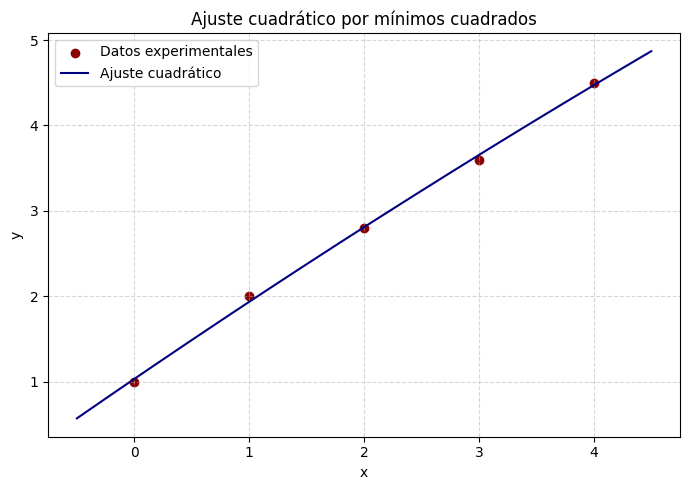

In [2]:
import matplotlib.pyplot as plt

# Datos originales
x = np.array([0, 1, 2, 3, 4], dtype=float)
y = np.array([1, 2, 2.8, 3.6, 4.5], dtype=float)

# Matriz de diseño A y vectores del sistema normal
A = np.vstack([np.ones_like(x), x, x**2]).T
ATA = A.T @ A
ATy = A.T @ y

# Resolución usando la función creada
beta = gaussian_elimination_solve(ATA, ATy)
b0, b1, b2 = beta
print("Coeficientes del modelo:", beta)

# Predicción
xx = np.linspace(x.min()-0.5, x.max()+0.5, 200)
yy = b0 + b1*xx + b2*xx**2

# Gráfico
plt.figure(figsize=(7,5))
plt.scatter(x, y, color='darkred', label='Datos experimentales')
plt.plot(xx, yy, color='navy', label='Ajuste cuadrático')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Ajuste cuadrático por mínimos cuadrados")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## d) Error cuadrático medio (MSE)

El error cuadrático medio se calcula como:

$$\mathrm{MSE} = \frac{1}{n}\sum_{i=1}^n \big(y_i - \hat{y}(x_i)\big)^2,$$

donde $\hat{y}(x) = \beta_0 + \beta_1 x + \beta_2 x^2$.

In [3]:
import numpy as np

y_hat = A @ beta
mse = np.mean((y - y_hat) ** 2)

print("MSE =", mse)
print("MSE (8 decimales) =", f"{mse:.8f}")

MSE = 0.0018285714285714183
MSE (8 decimales) = 0.00182857


# 2. Interpretación mediante SVD

En este punto analizamos la matriz de diseño \(A\) mediante su descomposición en valores singulares (SVD):
$$A = U\,\Sigma\,V^{\top},$$
donde \(U\) y \(V\) son matrices ortogonales y \(\Sigma=\operatorname{diag}(\sigma_1,\sigma_2,\sigma_3)\) con \(\sigma_1\ge\sigma_2\ge\sigma_3>0\).

Haremos:
- verificar ortogonalidad de \(U\);
- calcular la solución por SVD: $$\hat\beta_{\text{SVD}}=V\,\Sigma^{-1}U^{\top}y;$$
- comparar con la solución por ecuaciones normales;
- evaluar condicionamiento y colinealidad.